# Synthesizing AIA Emission with `synthesizAR`
This notebook will give a (hopefully!) working example of how to use `synthesizAR` to calculate the emission in each channel of the AIA instrument onboard SDO by folding the density into the temperature response functions and then integrating through our active region.

In [1]:
import os
import subprocess
import pickle
import logging

import numpy as np
import scipy
import seaborn as sns
import sunpy.map
import h5py
import astropy.units as u
from sunpy.net import vso
import matplotlib.pyplot as plt
from IPython.display import HTML

import synthesizAR
from synthesizAR.model_ext import EbtelInterface,PowerLawScaledWaitingTimes
from synthesizAR.instruments import InstrumentSDOAIA

sns.set_context(context='notebook',font_scale=1.5)
logging.basicConfig(level=logging.INFO)
%matplotlib inline

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Field Skeleton
Query the VSO to get the HMI image that we need. Then, build up a 3D skeleton of field lines.

In [ ]:
client = vso.VSOClient()
result_hmi = client.query(
     vso.attrs.Time((2013, 1, 1, 7, 34, 0), (2013, 1, 1, 9, 0, 0)),
     vso.attrs.Instrument('HMI'),
     vso.attrs.Physobs('LOS_magnetic_field'),   # Physical observables
     vso.attrs.Sample(5000 * u.s)
)
data_hmi = client.get(result_hmi,methods=('URL-FILE_Rice','URL-FILE')).wait()

In [ ]:
crop = (u.Quantity([-140,90]*u.arcsec),u.Quantity([420,560]*u.arcsec))
resample = u.Quantity([100,100]*u.pixel)
field = synthesizAR.Skeleton(data_hmi[0],crop=crop,resample=resample)
zshape=50
zrange=u.Quantity([0.,150.]*u.arcsec)
field.extrapolate_field(zshape,zrange)

In [ ]:
field.extract_streamlines(500)

In [ ]:
field.peek(alpha=0.35)

## Hydrodynamics

In [ ]:
field.make_loops()

In [ ]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'average_waiting_time':3000.0,
    'stress_level':0.05,
    'alpha':-2.5,
    'delta_power_law_bounds':100,
    'waiting_time_scaling':1.0,
}
heating_model = PowerLawScaledWaitingTimes(heating_options)

In [ ]:
ih = synthesizAR.util.InputHandler(os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-12
base_config['adaptive_solver_safety'] = 0.01
base_config['total_time'] = 10000.0
ebtel_plug = EbtelInterface(base_config,heating_model)
field.configure_loop_simulations(ebtel_plug,
                                 parent_config_dir='/data/datadrive2/ar_viz/simple_aia_synthesis/hydro_config/',
                                 parent_results_dir='/data/datadrive2/ar_viz/simple_aia_synthesis/hydro_results')

In [ ]:
for loop in field.loops:
    subprocess.call([os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
field.load_loop_simulations(ebtel_plug,savefile='/data/datadrive2/ar_viz/simple_aia_synthesis/loop_parameters.h5')

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
for l in field.loops:
    ax[0].plot(l.time,l.temperature[:,0],color=sns.color_palette('deep')[0],alpha=0.08)
    ax[1].plot(l.time,l.density[:,0],color=sns.color_palette('deep')[2],alpha=0.08)
ax[0].set_ylabel(r'$T$ ({0})'.format(l.temperature.unit.to_string()))
ax[1].set_ylabel(r'$n$ ({})'.format(l.density.unit))
ax[1].set_xlabel(r'$t$ ({})'.format(l.time.unit))

Save the field here for convenience.

In [ ]:
field.save_field(savedir='/data/datadrive2/ar_viz/simple_aia_synthesis/checkpoint')

And reload the field here (if needed).

In [3]:
field = synthesizAR.Skeleton.restore('/data/datadrive2/ar_viz/simple_aia_synthesis/checkpoint')

yt : [INFO     ] 2016-12-13 11:57:05,714 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-12-13 11:57:05,715 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2016-12-13 11:57:05,716 Parameters: domain_left_edge          = [ -9.60112377e+09   3.00297576e+10   4.25949509e+08]
yt : [INFO     ] 2016-12-13 11:57:05,717 Parameters: domain_right_edge         = [  6.06890905e+09   3.95486152e+10   1.02227882e+10]
yt : [INFO     ] 2016-12-13 11:57:05,718 Parameters: cosmological_simulation   = 0.0


## Synthesizing Observations
Now we'll use the instrument module and `Observer` object to configure a given observation over a given area for a specific amount of time.

First, create an object for each instrument that will observe our data. In `synthesizAR` several standard instruments (AIA, Hinode/EIS) will be included, but the user is free to define their own, provided it has the required methods.

In [5]:
observing_time = [0.0,10000]*u.s
aia = InstrumentSDOAIA(observing_time,use_temperature_response_functions=True,
                       response_function_file='aia_tresponse_raw.dat')

Next, pass the list of instruments to the observer object. The observer object coordinates the observation of the active region by multiple instruments and builds SunPy maps from the observations with the required metadata.

In [ ]:
ar_observer = synthesizAR.Observer(field,[aia],ds=0.3*u.arcsec)

In [ ]:
#reload temporary coordinates and set counts file for each instrument
with open('/data/datadrive2/ar_viz/simple_aia_synthesis/_tmp_coordinates.pickle','rb') as f:
    ar_observer.total_coordinates = pickle.load(f)
ar_observer.instruments[0].counts_file = '/data/datadrive2/ar_viz/simple_aia_synthesis/SDO_AIA_counts.h5'
#now skip the next two steps

Build the files to store the detector counts.

In [ ]:
ar_observer.build_detector_files('/data/datadrive2/ar_viz/simple_aia_synthesis/')

Now, calculate the detector counts for each channel.

In [ ]:
ar_observer.calculate_detector_counts()

In [ ]:
#temporary, need to create save and reload methods for observer
with open('/data/datadrive2/ar_viz/simple_aia_synthesis/_tmp_coordinates.pickle','wb') as f:
    pickle.dump(ar_observer.total_coordinates,f)

Finally, bin the counts into 2D maps and save them as FITS files.

In [ ]:
ar_observer.bin_detector_counts('/data/datadrive2/ar_viz/simple_aia_synthesis/maps',apply_psf=True)

# Visualization
Not sure if the visualization stuff should be wrapped up into the package? Should each instrument have a visualization method? Just let the user sort all of that out on their own?

Grab a map from each channel.

Assign colorbar ranges for each channel. Maybe this can eventually be done for each instrument class.

In [ ]:
intensity_ranges = {
    '94':[.01,5],
    '131':[1,50],
    '171':[10,1000],
    '193':[10,500],
    '211':[10,500],
    '335':[.1,20]
}

In [ ]:
fits_file_template = '/data/datadrive2/ar_viz/simple_aia_synthesis/maps/SDO_AIA/{channel}/map_t{time:06d}.fits'
save_file_template = '/data/datadrive2/ar_viz/simple_aia_synthesis/maps/SDO_AIA/figs/all_channels_t{time:06d}.pdf'
fig = plt.figure(figsize=(14,6))
for j,time in enumerate(aia.observing_time):
    fig.suptitle(r'$t=${0} ({1})'.format(time,aia.observing_time.unit),fontsize=16)
    for i,channel in enumerate(aia.channels):
        _tmp_map = sunpy.map.Map(fits_file_template.format(channel=channel['name'],time=j))
        ax = fig.add_subplot(2,3,i+1,projection=_tmp_map)
        _tmp_map.plot(axes=ax,vmin=intensity_ranges[channel['name']][0],
                      vmax=intensity_ranges[channel['name']][1],
                      annotate=False)
        ax.set_title(r'{0} $\mathrm{{\mathring{{A}}}}$'.format(channel['name']))
        if i>2:
            ax.set_xlabel(r'$x$ ({})'.format(_tmp_map.xrange.unit))
        if i==0 or i==3:
            ax.set_ylabel(r'$y$ ({})'.format(_tmp_map.yrange.unit))
    plt.savefig(save_file_template.format(time=j))
    fig.clf()

Make a gif with ImageMagick

In [ ]:
%%bash
convert -delay 2 -loop 0 /data/datadrive2/ar_viz/simple_aia_synthesis/maps/SDO_AIA/figs/*.pdf aia_all_channels.gif

In [15]:
HTML('<img src="aia_all_channels.gif"/>')

## Individual Loop Intensities

In [11]:
loop_counts = {}
test_loop = field.loops[100]
for channel in aia.channels:
    loop_counts[channel['name']] = aia._detect_simple(test_loop,channel)

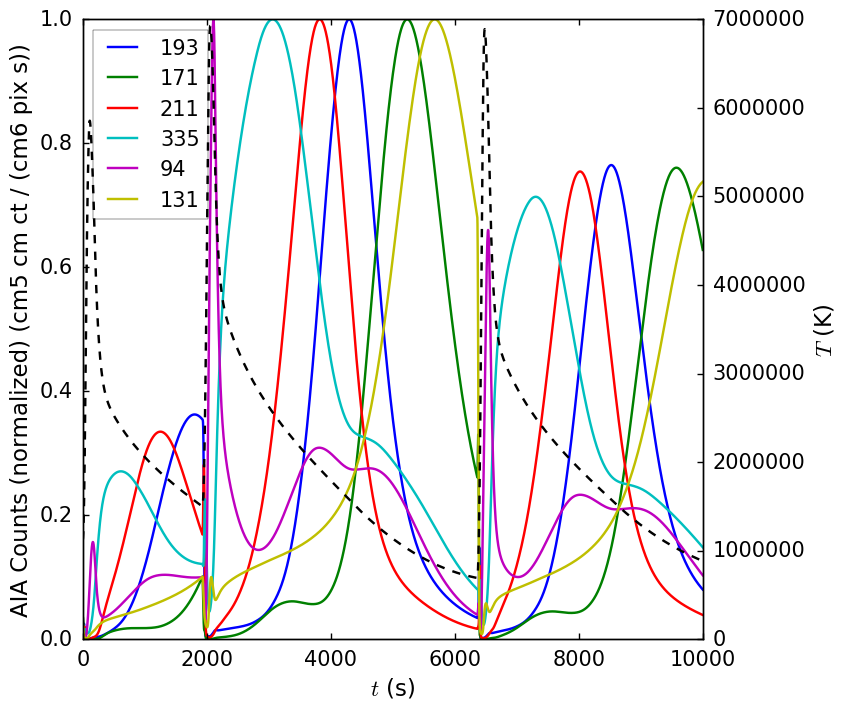

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
axT = ax.twinx()
axT.plot(test_loop.time,test_loop.temperature[:,0],'--k')
for channel in loop_counts:
    integrated_intensity = loop_counts[channel][:,0]*test_loop.full_length/2.0
    ax.plot(test_loop.time,(integrated_intensity/np.max(integrated_intensity)),
            label=r'{}'.format(channel))
ax.set_ylabel(r'AIA Counts (normalized) ({})'.format(loop_counts[channel].unit*test_loop.full_length.unit))
ax.set_xlabel(r'$t$ ({})'.format(test_loop.time.unit))
axT.set_ylabel(r'$T$ ({})'.format(test_loop.temperature.unit))
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.legend(loc='best')
#ax.set_xlim([2000,6000])

Try out a cross-correlation similar to what is done in the time-lag analysis

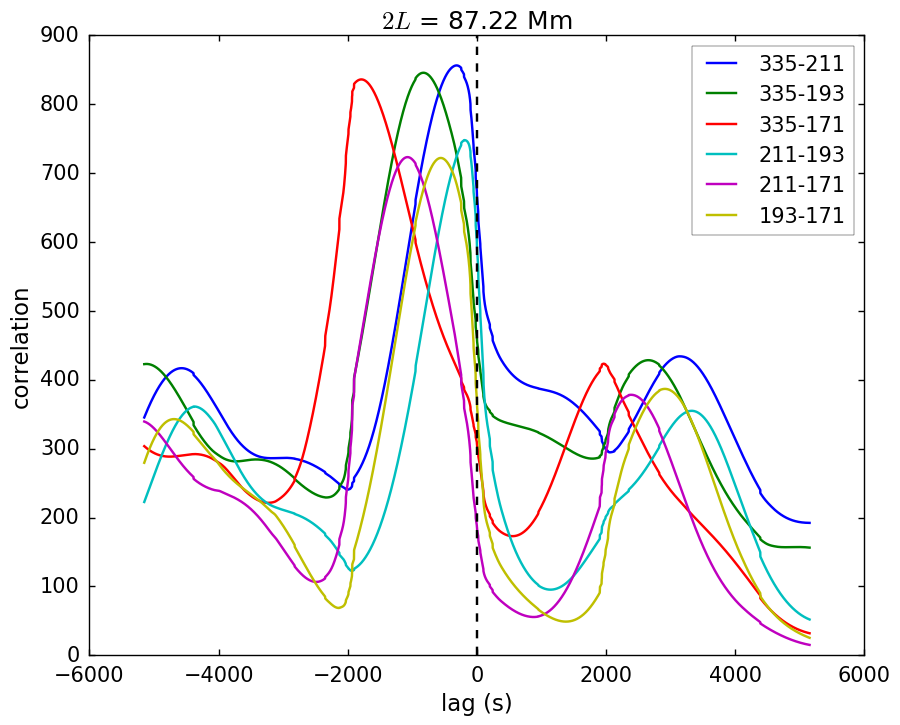

In [14]:
pairs = [(335,211),(335,193),(335,171),(211,193),(211,171),(193,171)]
pairs = pairs #+ [(p[1],p[0]) for p in pairs]
data = []
for p in pairs:
    int1 = loop_counts['{}'.format(p[0])][:,0]*test_loop.full_length/2.0
    int2 = loop_counts['{}'.format(p[1])][:,0]*test_loop.full_length/2.0
    lag_indices,cor,_,_ = plt.xcorr((int1/np.max(int1)),(int2/np.max(int2)),normed=False,
                                    usevlines=False,maxlags=3000)
    plt.close()
    lag = np.array([-test_loop.time[-li].value if li<0 else test_loop.time[li].value for li in lag_indices])*test_loop.time.unit
    data.append({'lags':lag,'cor':cor})
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
for p,d in zip(pairs,data):
    ax.plot(d['lags'],d['cor'],label=r'{}-{}'.format(p[0],p[1]))
#ax.set_xlim([-2500,2500])
ax.axvline(x=0.0,color='k',linestyle='--')
ax.set_title(r'$2L$ = {L:2.2f}'.format(L=test_loop.full_length.to(u.Mm),Lu=u.Mm))
ax.legend(loc='best')
ax.set_xlabel(r'lag ({})'.format(lag.unit))
ax.set_ylabel(r'correlation')